In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.229, 0.225])
])
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_f = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_f, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512), 
    nn.Dropout(0.2),
    nn.Linear(512, 6)
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    return model, history
trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")
    
np.mean(history["val_acc"])

In [ ]:
num_classes = len(train_dataset.classes)
print(f"Количество классов в наборе данных: {num_classes}")


In [ ]:
train_labels = [label for _, label in train_dataset.samples]
print(f"Уникальные метки в тренировочном наборе: {np.unique(train_labels)}")


In [ ]:
for inputs, labels in train_loader:
    print(f"Размер пакета: {inputs.size()}")


In [ ]:
print(f"Первый индекс тренировочного набора: {train_idx[0]}")
print(f"Первый индекс валидационного набора: {val_idx[0]}")


In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_f = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_f, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512), 
    nn.Dropout(0.2),
    nn.Linear(512, len(train_dataset.classes))
)

# Move model to device
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, num_epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

# Train the model
trained_model, history = train_model(model, criterion, optimizer, num_epochs=10)

# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print analysis
print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")

In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128), 
    nn.Dropout(0.2),
    nn.Linear(128, len(train_dataset.classes))
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.fc.parameters(), momentum=0.9, lr=0.001)
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs.logits
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs.logits
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

trained_model, history = train_model(model, criterion, optimizer, num_epochs=30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")

In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.googlenet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
        nn.BatchNorm1d(128), 
    nn.Dropout(0.2),
    nn.Linear(128, len(train_dataset.classes))
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.fc.parameters(), momentum=0.9, lr=0.001)
def train_model(model, criterion, optimizer, num_epochs=20):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs.logits
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs.logits
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

trained_model, history = train_model(model, criterion, optimizer, num_epochs=20)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")

Train directory: /kaggle/input/crab-species-datasets/train/train
Test directory: /kaggle/input/crab-species-datasets/test/test
Using device: cuda
Epoch 1/50 - Train Loss: 1.6298 Acc: 0.3435 - Val Loss: 1.3044 Acc: 0.6667
Epoch 2/50 - Train Loss: 1.0156 Acc: 0.6947 - Val Loss: 0.9210 Acc: 0.7424
Epoch 3/50 - Train Loss: 0.7837 Acc: 0.7710 - Val Loss: 0.7020 Acc: 0.8333
Epoch 4/50 - Train Loss: 0.6238 Acc: 0.8511 - Val Loss: 0.6299 Acc: 0.8333
Epoch 5/50 - Train Loss: 0.5075 Acc: 0.8664 - Val Loss: 0.5612 Acc: 0.8788
Epoch 6/50 - Train Loss: 0.4675 Acc: 0.8817 - Val Loss: 0.5134 Acc: 0.8939
Epoch 7/50 - Train Loss: 0.3982 Acc: 0.9198 - Val Loss: 0.4944 Acc: 0.8485
Epoch 8/50 - Train Loss: 0.3773 Acc: 0.9122 - Val Loss: 0.4968 Acc: 0.8485
Epoch 9/50 - Train Loss: 0.3542 Acc: 0.9160 - Val Loss: 0.5149 Acc: 0.8788
Epoch 10/50 - Train Loss: 0.3127 Acc: 0.9160 - Val Loss: 0.4800 Acc: 0.8333
Epoch 11/50 - Train Loss: 0.3229 Acc: 0.9275 - Val Loss: 0.4586 Acc: 0.8636
Epoch 12/50 - Train Loss: 0

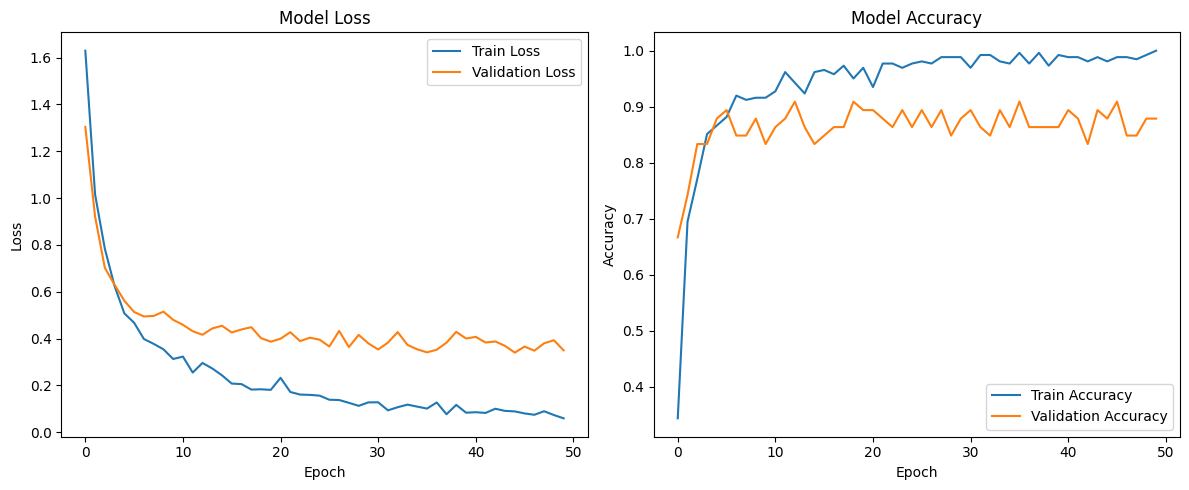


Анализ данных:
Количество тренировочных образцов: 262
Количество валидационных образцов: 66
Количество тестовых образцов: 30

Распределение классов (тренировочный набор):
Класс blue_crab: 70 образцов
Класс coconut_crab: 70 образцов
Класс king_crab: 46 образцов
Класс mud_crab: 40 образцов
Класс stone_crab: 40 образцов
Класс vampire_crab: 62 образцов

Среднее значение точности на валидационном наборе: 0.8645


In [7]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.alexnet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256), 
    nn.Dropout(0.2),
    nn.Linear(256, len(train_dataset.classes))
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.0001)

def train_model(model, criterion, optimizer, num_epochs=20):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

trained_model, history = train_model(model, criterion, optimizer, num_epochs=50)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")

Train directory: /kaggle/input/crab-species-datasets/train/train
Test directory: /kaggle/input/crab-species-datasets/test/test
Using device: cuda
Epoch 1/50 - Train Loss: 1.8536 Acc: 0.2023 - Val Loss: 1.6025 Acc: 0.3485
Epoch 2/50 - Train Loss: 1.4318 Acc: 0.4733 - Val Loss: 1.3016 Acc: 0.6818
Epoch 3/50 - Train Loss: 1.1875 Acc: 0.6412 - Val Loss: 1.0802 Acc: 0.7576
Epoch 4/50 - Train Loss: 0.9911 Acc: 0.6870 - Val Loss: 0.8965 Acc: 0.7727
Epoch 5/50 - Train Loss: 0.8301 Acc: 0.7634 - Val Loss: 0.7869 Acc: 0.7879
Epoch 6/50 - Train Loss: 0.7657 Acc: 0.7824 - Val Loss: 0.7472 Acc: 0.8333
Epoch 7/50 - Train Loss: 0.6614 Acc: 0.8282 - Val Loss: 0.6907 Acc: 0.8636
Epoch 8/50 - Train Loss: 0.6235 Acc: 0.8473 - Val Loss: 0.6211 Acc: 0.8788
Epoch 9/50 - Train Loss: 0.6006 Acc: 0.8473 - Val Loss: 0.5844 Acc: 0.8788
Epoch 10/50 - Train Loss: 0.5268 Acc: 0.8855 - Val Loss: 0.5929 Acc: 0.8485
Epoch 11/50 - Train Loss: 0.5264 Acc: 0.8588 - Val Loss: 0.5664 Acc: 0.8939
Epoch 12/50 - Train Loss: 0

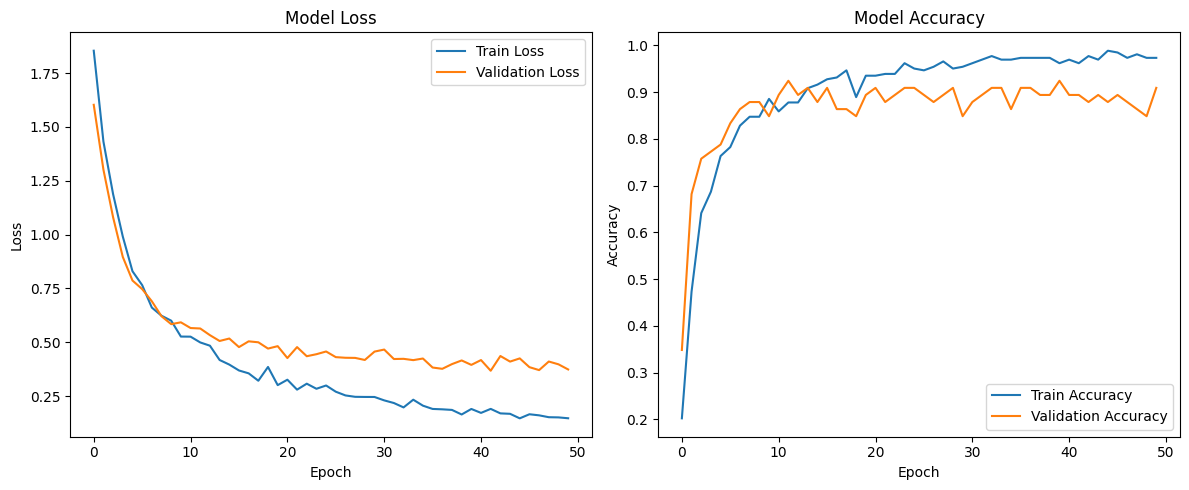


Анализ данных:
Количество тренировочных образцов: 262
Количество валидационных образцов: 66
Количество тестовых образцов: 30

Распределение классов (тренировочный набор):
Класс blue_crab: 70 образцов
Класс coconut_crab: 70 образцов
Класс king_crab: 46 образцов
Класс mud_crab: 40 образцов
Класс stone_crab: 40 образцов
Класс vampire_crab: 62 образцов

Среднее значение точности на валидационном наборе: 0.8655


In [4]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

root_dir = "/kaggle/input/crab-species-datasets"

train_dir = os.path.join(root_dir, "train/train")
test_dir = os.path.join(root_dir, "test/test")

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_idx, val_idx = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.alexnet(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256), 
    nn.Dropout(0.2),
    nn.Linear(256, len(train_dataset.classes))
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.00005)

def train_model(model, criterion, optimizer, num_epochs=20):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    for ep in range(num_epochs):
        model.train()
        full_loss = 0.0
        full_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
            full_loss += loss.item()*inputs.size(0)
            full_corrects += torch.sum(preds==labels.data)
        
        ep_loss = full_loss / len(train_idx)
        ep_acc = full_corrects.double() / len(train_idx)
        
        history["train_loss"].append(ep_loss)
        history["train_acc"].append(ep_acc.item())
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds==labels.data)
                
        val_ep_loss = val_loss / len(val_idx)
        val_ep_acc = val_corrects.double() / len(val_idx)
        
        history["val_loss"].append(val_ep_loss)
        history["val_acc"].append(val_ep_acc.item())
        
        print(f'Epoch {ep+1}/{num_epochs} - '
              f'Train Loss: {ep_loss:.4f} Acc: {ep_acc:.4f} - '
              f'Val Loss: {val_ep_loss:.4f} Acc: {val_ep_acc:.4f}')
    
    return model, history

trained_model, history = train_model(model, criterion, optimizer, num_epochs=50)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\nАнализ данных:")
print(f"Количество тренировочных образцов: {len(train_idx)}")
print(f"Количество валидационных образцов: {len(val_idx)}")
print(f"Количество тестовых образцов: {len(test_dataset)}")
print("\nРаспределение классов (тренировочный набор):")
train_labels = [label for _, label in train_dataset.samples]
for i, count in enumerate(np.bincount(train_labels)):
    print(f"Класс {train_dataset.classes[i]}: {count} образцов")

print(f"\nСреднее значение точности на валидационном наборе: {np.mean(history['val_acc']):.4f}")